In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import cyecca.lie as lie
from cyecca.lie.group_so3 import SO3Quat, SO3EulerB321, so3, SO3Dcm
from cyecca.lie.group_se23 import SE23Quat, se23
from scipy.spatial.transform import Rotation

# MCAP/ROS bag reading imports
try:
    import rclpy
    from rclpy.serialization import deserialize_message
    from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
    from nav_msgs.msg import Odometry
    from sensor_msgs.msg import Imu, MagneticField
    MCAP_AVAILABLE = True
    print("MCAP reading libraries available")
except ImportError as e:
    MCAP_AVAILABLE = False
    print(f"MCAP reading libraries not available: {e}")
    print("Please install: pip install ros2bag rosbag2-py")

# Set up plotting
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')  # fallback for older versions
    except:
        pass  # use default style if seaborn not available
plt.rcParams['figure.figsize'] = (12, 8)


MCAP reading libraries available


In [231]:
# Constants
g = 9.8  # gravity acceleration m/s^2

def angle_wrap(angle):
    """Wrap angle to [-pi, pi]"""
    wrapped = ca.fmod(angle, 2 * ca.pi)
    wrapped = ca.if_else(wrapped < 0, wrapped + 2 * ca.pi, wrapped)
    return ca.if_else(wrapped > ca.pi, wrapped - 2 * ca.pi, wrapped)

def quat_to_euler(q):
    """Convert quaternion [w,x,y,z] to Euler angles [roll,pitch,yaw]"""
    r = Rotation.from_quat([q[1], q[2], q[3], q[0]])  # scipy uses [x,y,z,w]
    return r.as_euler('xyz', degrees=True)  # roll, pitch, yaw in degrees


In [232]:
def read_mcap_data(mcap_file_path, odom_topic="/odom", imu_topic="/imu", mag_topic="/mag"):
    """Read IMU, magnetometer, and true attitude data from MCAP file.
    
    Args:
        mcap_file_path: Path to the MCAP file
        odom_topic: Odometry topic name (true attitude)
        imu_topic: IMU topic name
        mag_topic: Magnetometer topic name
        
    Returns:
        Tuple of (imu_df, mag_df, odom_df) DataFrames
    """
    if not MCAP_AVAILABLE:
        print("MCAP libraries not available")
        return None, None, None
        
    try:
        # Set up MCAP reader
        storage_options = StorageOptions(uri=mcap_file_path, storage_id='mcap')
        converter_options = ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
        
        reader = SequentialReader()
        reader.open(storage_options, converter_options)
        
        # Storage for data
        imu_data = []
        mag_data = []
        odom_data = []
        
        print(f"Reading data from {mcap_file_path}")
        print(f"Looking for topics: {odom_topic}, {imu_topic}, {mag_topic}")
        
        msg_count = 0
        while reader.has_next():
            current_topic, msg_data, _ = reader.read_next()
            msg_count += 1
            
            if msg_count % 1000 == 0:
                print(f"Processed {msg_count} messages...")
            
            if current_topic == odom_topic:
                # Deserialize odometry message
                msg = deserialize_message(msg_data, Odometry)
                
                # Extract orientation (quaternion)
                ori = msg.pose.pose.orientation
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Store quaternion components directly (ROS uses [x, y, z, w] format)
                qx, qy, qz, qw = ori.x, ori.y, ori.z, ori.w
                
                # Also convert to Euler angles for backward compatibility and plotting
                r = Rotation.from_quat([ori.x, ori.y, ori.z, ori.w])
                euler_rad = r.as_euler('xyz', degrees=False)  # [roll, pitch, yaw] in radians
                euler_deg = np.degrees(euler_rad)  # Convert to degrees
                
                odom_data.append({
                    'timestamp': timestamp,
                    'qw': qw,  # Quaternion w component
                    'qx': qx,  # Quaternion x component  
                    'qy': qy,  # Quaternion y component
                    'qz': qz,  # Quaternion z component
                    'roll': euler_deg[0],
                    'pitch': euler_deg[1], 
                    'yaw': euler_deg[2]
                })
                
            elif current_topic == imu_topic:
                # Deserialize IMU message
                msg = deserialize_message(msg_data, Imu)
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Extract gyroscope data (rad/s)
                gyro_x = msg.angular_velocity.x
                gyro_y = msg.angular_velocity.y
                gyro_z = msg.angular_velocity.z
                
                # Extract accelerometer data (m/s^2)
                accel_x = msg.linear_acceleration.x
                accel_y = msg.linear_acceleration.y
                accel_z = msg.linear_acceleration.z
                
                imu_data.append({
                    'timestamp': timestamp,
                    'gyro_x': gyro_x,
                    'gyro_y': gyro_y,
                    'gyro_z': gyro_z,
                    'accel_x': accel_x,
                    'accel_y': accel_y,
                    'accel_z': accel_z
                })
                
            elif current_topic == mag_topic:
                # Deserialize magnetometer message
                msg = deserialize_message(msg_data, MagneticField)
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Extract magnetic field data
                mag_x = msg.magnetic_field.x
                mag_y = msg.magnetic_field.y
                mag_z = msg.magnetic_field.z
                
                mag_data.append({
                    'timestamp': timestamp,
                    'mag_x': mag_x,
                    'mag_y': mag_y,
                    'mag_z': mag_z
                })
        
        reader.close()
        
        # Convert to DataFrames
        imu_df = pd.DataFrame(imu_data) if imu_data else None
        mag_df = pd.DataFrame(mag_data) if mag_data else None
        odom_df = pd.DataFrame(odom_data) if odom_data else None
        
        print(f"\nData loaded:")
        if imu_df is not None:
            print(f"IMU: {len(imu_df)} samples, time range: {imu_df['timestamp'].min():.2f} - {imu_df['timestamp'].max():.2f} s")
        if mag_df is not None:
            print(f"Magnetometer: {len(mag_df)} samples, time range: {mag_df['timestamp'].min():.2f} - {mag_df['timestamp'].max():.2f} s")
        if odom_df is not None:
            print(f"True attitude: {len(odom_df)} samples, time range: {odom_df['timestamp'].min():.2f} - {odom_df['timestamp'].max():.2f} s")
        
        return imu_df, mag_df, odom_df
        
    except Exception as e:
        print(f"Error reading MCAP file: {e}")
        return None, None, None


In [233]:
def derive_strapdown_ins_propagation():
    """INS strapdown propagation using SE(2,3) group"""
    dt = ca.SX.sym("dt")
    X0 = lie.SE23Quat.elem(ca.SX.sym("X0", 10))
    a_b = ca.SX.sym("a_b", 3)
    g_val = ca.SX.sym("g")
    omega_b = ca.SX.sym("omega_b", 3)
    l = lie.se23.elem(ca.vertcat(0, 0, 0, a_b, omega_b))
    r = lie.se23.elem(ca.vertcat(0, 0, 0, 0, 0, -g_val, 0, 0, 0))
    B = ca.sparsify(ca.SX([[0, 1], [0, 0]]))
    X1 = lie.SE23Quat.exp_mixed(X0, l * dt, r * dt, B * dt)
    
    f_ins = ca.Function(
        "strapdown_ins_propagate",
        [X0.param, a_b, omega_b, g_val, dt],
        [X1.param],
        ["x0", "a_b", "omega_b", "g", "dt"],
        ["x1"]
    )
    
    return f_ins

def extract_quaternion_from_se23(X):
    """Extract quaternion from SE(2,3) state vector"""
    # SE(2,3) state: [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, qw, qx, qy, qz]
    return X[6:10]  # quaternion is at indices 6-9

def create_se23_state(pos, vel, quat):
    """Create SE(2,3) state vector from position, velocity, and quaternion"""
    return np.concatenate([pos, vel, quat])

# Create the functions
ins_propagate = derive_strapdown_ins_propagation()

In [234]:
def derive_attitude_estimator_basic():
    """Attitude estimator using magnetometer and accelerometer corrections"""
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # Correction angular velocity vector
    omega_w = ca.SX.zeros(3, 1)

    # --- Magnetometer correction (yaw) ---
    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2)

    # Check if magnetometer is not too vertical
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))
    mag_error_w = ca.if_else(ca.sin(gamma) > 0.1, mag_error_w, 0)

    # Apply magnetometer correction
    omega_w += ca.vertcat(0, 0, mag_error_w) * mag_gain

    # --- Accelerometer correction (roll/pitch) ---
    # Transform acceleration to world frame
    accel_w = q_wb @ accel_b
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm
    

    # Only correct if acceleration is close to gravity
    threshold = 0.1
    higher_lim_check = ca.if_else(accel_norm < g * (1 + threshold), 1, 0)
    lower_lim_check = ca.if_else(accel_norm > g * (1 - threshold), 1, 0)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Reduce gain when accelerating
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)

    accel_error = ca.cross(ca.vertcat(0, 0, 1), accel_w_normed) 

    # Calculate correction
    accel_correction = (
        ca.vertcat(accel_error[0], accel_error[1], 0)
        * accel_gain
        * accel_norm_check
        * accel_gain_magnitude
    )
    omega_w -= accel_correction

    # Apply correction
    q1 = so3.elem(omega_w * dt).exp(SO3Quat) * q_wb

    # Return estimator function
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [q0, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1.param, q1.param],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "dt"],
        ["q1", "q_dot_corr"]
    )

    return f_att_estimator

attitude_estimator_basic = derive_attitude_estimator_basic()

In [235]:
def derive_attitude_estimator_IEKF():
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)
    P = ca.SX.sym("P", 3, 3)

    # Note:
    # Magnetometer frame: x is east, y is north, z is up
    # Body frame: x is forward, y is left, z is down
    # World frame: x is east, y is north, z is up

    # Correction angular velocity vector
    error_w = ca.SX.zeros(3, 1)

    # # --- Correction from magnetometer (yaw) ---

    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2) # the magnetic north is at (90 degrees - mag_decl) yaw

    # mag check
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))  # angle from vertical
    mag_error_check = ca.if_else(ca.sin(gamma) > 0.1, 0, 1)

    error_w += (ca.vertcat(0,0,mag_error_w))

    # # --- Correction from accelerometer (roll/pitch) ---

    # Transform acceleration in world frame
    accel_w = q_wb @ accel_b 
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm

    # Correct accelerometer only if g between 0.9g and 1.1g
    threshold = 0.05
    higher_lim_check = ca.if_else(ca.fabs(accel_w_normed[2]) < (1 + threshold), 0, 1) * ca.if_else(accel_norm < g * (1 + threshold), 0, 1)
    lower_lim_check = ca.if_else(ca.fabs(accel_w_normed[2]) > (1 - threshold), 0, 1) * ca.if_else(accel_norm > g * (1 - threshold), 0, 1)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Acceleration gain
    # If the drone is accelerating, we shouldn't trust the accelerometer
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)
    
    # Correct gravity as z
    error_w -= (
        ca.cross(ca.vertcat(0,0,1), ca.vertcat(accel_w_normed[0],accel_w_normed[1],accel_w_normed[2]))
    )

    ## TODO add gyro bias stuff

    pitch_cov = 1e-1
    roll_cov = 1e-1
    yaw_cov = 1e-1
    
    L = ca.SX.zeros(3, 3)
    L[0,0] = pitch_cov / (accel_gain_magnitude * accel_gain) + 1e4 * accel_norm_check
    L[1,1] = roll_cov / (accel_gain_magnitude * accel_gain) + 1e4 * accel_norm_check
    L[2,2] = yaw_cov / (mag_gain) + 1e4 * mag_error_check
    Q = ca.SX.eye(3) * 1e-6

    # --- IEKF ---
    R = SO3Dcm.from_Quat(q_wb).to_Matrix()
    # Predict covariance
    F = so3.wedge(omega_b * dt).exp(SO3Dcm).to_Matrix()
    P_new = F @ P @ F.T + Q

    # Kalman Gain calculation
    H = ca.SX.eye(3)
    S = H @ P_new @ H.T + L
    K = P_new @ H.T @ ca.inv(S)

    # Correction
    correction_w = K @ error_w

    # Add saturation to prevent large jumps
    max_correction = 0.1  # radians, tune this value
    correction_norm = ca.norm_2(correction_w)
    correction_w = ca.if_else(
        correction_norm > max_correction,
        correction_w * max_correction / correction_norm,
        correction_w
    )

    q1 = so3.wedge(correction_w * dt).exp(SO3Quat) * q_wb

    # Return estimator
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [
            q0,
            mag_b,
            mag_decl,
            omega_b,
            accel_b,
            accel_gain,
            mag_gain,
            dt,
            P,
        ],
        [q1.param, P_new],
        [
            "q",
            "mag_b",
            "mag_decl",
            "omega_b",
            "accel_b",
            "accel_gain",
            "mag_gain",
            "dt",
            "P",
        ],
        ["q1", "P_new"],
    )

    return f_att_estimator

attitude_estimator_IEKF = derive_attitude_estimator_IEKF()

In [236]:
def derive_attitude_estimator_PX4() -> ca.Function:
    """Builds a CasADi function implementing PX4-style attitude corrections (mag + accel).

    This function computes attitude corrections using magnetometer and accelerometer
    following the PX4 AttitudeEstimatorQ logic, excluding gyro integration (assumed
    handled elsewhere). The quaternion is updated using only the correction term.

    Args:
        None

    Returns:
        casadi.Function: A function with signature:
            attitude_estimator(q, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt) -> q1

            - q (4x1): Quaternion [qw, qx, qy, qz]
            - mag_b (3x1): Magnetometer measurement in body frame
            - mag_decl (1x1): Magnetic declination (rad)
            - omega_b (3x1): Body angular rate for spin-gain scheduling (rad/s)
            - accel_b (3x1): Accelerometer measurement in body frame (m/s^2)
            - accel_gain (1x1): Accelerometer correction gain
            - mag_gain (1x1): Magnetometer correction gain
            - dt (1x1): Timestep for applying the correction (s)

            - q1 (4x1): Corrected and normalized quaternion
    """

    def normalize_quat(q: ca.SX) -> ca.SX:
        norm_q = ca.norm_2(q)
        return q / (norm_q + 1e-12)

    def normalize_vec(v: ca.SX) -> ca.SX:
        n = ca.norm_2(v)
        return v / (n + 1e-12)

    def wrap_pi(angle: ca.SX) -> ca.SX:
        # Numerically robust wrap using atan2(sin, cos)
        return ca.atan2(ca.sin(angle), ca.cos(angle))

    def quat_to_rotmat(q: ca.SX) -> ca.SX:
        # q = [qw, qx, qy, qz]
        qw, qx, qy, qz = q[0], q[1], q[2], q[3]

        # Rotation matrix corresponding to quaternion (body -> earth)
        # Matches conventional Hamiltonian quaternion with qw as scalar part
        r00 = 1 - 2 * (qy * qy + qz * qz)
        r01 = 2 * (qx * qy - qz * qw)
        r02 = 2 * (qx * qz + qy * qw)

        r10 = 2 * (qx * qy + qz * qw)
        r11 = 1 - 2 * (qx * qx + qz * qz)
        r12 = 2 * (qy * qz - qx * qw)

        r20 = 2 * (qx * qz - qy * qw)
        r21 = 2 * (qy * qz + qx * qw)
        r22 = 1 - 2 * (qx * qx + qy * qy)

        return ca.vertcat(
            ca.horzcat(r00, r01, r02),
            ca.horzcat(r10, r11, r12),
            ca.horzcat(r20, r21, r22),
        )

    def quat_omega_dot(q: ca.SX, omega_b: ca.SX) -> ca.SX:
        # q_dot = 0.5 * q ⊗ [0, omega]
        qw, qx, qy, qz = q[0], q[1], q[2], q[3]
        ox, oy, oz = omega_b[0], omega_b[1], omega_b[2]
        r0, r1, r2, r3 = 0, ox, oy, oz

        dq0 = qw * r0 - qx * r1 - qy * r2 - qz * r3
        dq1 = qw * r1 + qx * r0 + qy * r3 - qz * r2
        dq2 = qw * r2 - qx * r3 + qy * r0 + qz * r1
        dq3 = qw * r3 + qx * r2 - qy * r1 + qz * r0

        return ca.vertcat(dq0, dq1, dq2, dq3)

    # Symbols
    q = ca.SX.sym("q", 4)
    mag_b = ca.SX.sym("mag_b", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel_b", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # Normalize quaternion first (matches PX4 normalization behavior)
    qn = normalize_quat(q)

    accel_b_minus = -accel_b

    # Compute spin rate for magnetometer gain scheduling
    spin_rate = ca.norm_2(omega_b)
    fifty_dps = 0.873  # ~50 deg/s in rad/s
    gain_mult = ca.if_else(
        spin_rate > fifty_dps,
        ca.fmin(spin_rate / fifty_dps, 10.0),
        1.0,
    )
    # Rotation: body -> earth
    R_be = quat_to_rotmat(qn)

    # Magnetometer correction (project mag to earth XY and compute heading error)
    mag_earth = R_be @ mag_b
    mag_err = -wrap_pi(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl + ca.pi / 2)

    # Project magnetometer correction vector [0, 0, -mag_err] (earth) to body frame
    z_err_earth = ca.vertcat(0.0, 0.0, -mag_err)
    # rotateVectorInverse is R_eb = R_be.T
    corr_mag = (R_be.T @ z_err_earth) * (mag_gain)

    # Accelerometer correction
    # Optimized k = R_eb * e_z using PX4 closed-form, where q = [qw, qx, qy, qz]
    qw, qx, qy, qz = qn[0], qn[1], qn[2], qn[3]
    k = ca.vertcat(
        2.0 * (qx * qz - qw * qy),
        2.0 * (qy * qz + qw * qx),
        (qw * qw - qx * qx - qy * qy + qz * qz),
    )

    #k = R_be.T @ ca.vertcat(0.0, 0.0, 1.0)

    # Apply 1g gating like PX4 (without GPS accel compensation)
    one_g = 9.80665
    upper = one_g * 1.1
    lower = one_g * 0.9
    accel_norm_sq = ca.dot(accel_b_minus, accel_b_minus)

    # accel_unit = (_accel - _pos_acc).normalized() with _pos_acc = 0
    accel_unit = normalize_vec(accel_b_minus)

    corr_acc_base = ca.cross(k, accel_unit) * accel_gain
    use_acc = ca.logic_and(accel_norm_sq > (lower * lower), accel_norm_sq < (upper * upper))
    corr_acc = ca.if_else(use_acc, corr_acc_base, ca.DM.zeros(3, 1))
    corr_acc = ca.vertcat(corr_acc[0], corr_acc[1], 0)

    # Total correction angular rate
    corr = corr_acc + corr_mag

    # Apply correction only (integrate correction to quaternion)
    q_dot_corr = quat_omega_dot(qn, corr)
    q1 = normalize_quat(qn + q_dot_corr * dt)

    f_att_estimator = ca.Function(
        "attitude_estimator",
        [q, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1, corr],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "corr"],
        ["q1", "q_dot_corr"],
    )

    return f_att_estimator

attitude_estimator_PX4 = derive_attitude_estimator_PX4()


In [237]:
def derive_attitude_estimator_adv():
    """Attitude estimator with separate roll/pitch and yaw corrections"""
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # --- STEP 1: Roll/Pitch Correction (preserving yaw) ---
    # Extract current Euler angles
    R_current = SO3Quat.to_Matrix(q_wb)
    current_roll = ca.atan2(R_current[2,1], R_current[2,2])
    current_pitch = ca.atan2(-R_current[2,0], ca.sqrt(R_current[2,1]**2 + R_current[2,2]**2))
    current_yaw = ca.atan2(R_current[1,0], R_current[0,0])
    
    # Accelerometer-based roll/pitch correction
    accel_norm = ca.norm_2(accel_b)
    
    # Gating for accelerometer
    threshold = 0.1
    accel_norm_check = ca.if_else(
        ca.logic_and(
            accel_norm > g * (1 - threshold),
            accel_norm < g * (1 + threshold)
        ), 1, 0
    )
    
    # Calculate desired roll and pitch from accelerometer
    desired_roll = ca.atan2(accel_b[1], accel_b[2])
    desired_pitch = ca.atan2(-accel_b[0], ca.sqrt(accel_b[1]**2 + accel_b[2]**2))
    
    # Roll and pitch errors
    roll_error = angle_wrap(desired_roll - current_roll)
    pitch_error = angle_wrap(desired_pitch - current_pitch)
    
    # Apply roll/pitch corrections with gain
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)
    
    corrected_roll = current_roll + roll_error * accel_gain * accel_norm_check * accel_gain_magnitude * dt
    corrected_pitch = current_pitch + pitch_error * accel_gain * accel_norm_check * accel_gain_magnitude * dt
    
    # Create intermediate quaternion with corrected roll/pitch, preserved yaw
    q_rp_corrected = SO3EulerB321.elem(ca.vertcat(current_yaw, corrected_pitch, corrected_roll))
    q_intermediate = SO3Quat.from_Euler(q_rp_corrected)
    
    # --- STEP 2: Yaw Correction (independent) ---
    # Transform magnetometer to world frame using intermediate quaternion
    mag_earth = q_intermediate @ mag_b
    
    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2)
    
    # Check if magnetometer is not too vertical
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))
    mag_error_check = ca.if_else(ca.sin(gamma) > 0.1, 1, 0)
    
    # Apply yaw correction
    yaw_correction = mag_error_w * mag_gain * mag_error_check * dt
    final_yaw = current_yaw + yaw_correction
    
    # Create final quaternion
    q_final = SO3EulerB321.elem(ca.vertcat(final_yaw, corrected_pitch, corrected_roll))
    q1 = SO3Quat.from_Euler(q_final)
    
    f_att_estimator = ca.Function(
        "attitude_estimator_with_yaw",
        [q0, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1.param, ca.vertcat(roll_error, pitch_error, mag_error_w)],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "dt"],
        ["q1", "errors"]
    )

    return f_att_estimator
attitude_estimator_adv = derive_attitude_estimator_adv()

In [238]:
# Parameters
MCAP_FILE_PATH = "rosbag/rosbag2_2025_08_12-17_41_37/rosbag2_2025_08_12-17_41_37_0.mcap"
ODOM_TOPIC = "/odom"      # True attitude
IMU_TOPIC = "/imu"        # IMU data
MAG_TOPIC = "/mag"        # Magnetometer data

# Estimator parameters
ACCEL_GAIN = 0.2   # Accelerometer correction gain
MAG_GAIN = 0.2       # Magnetometer correction gain
MAG_DECLINATION = -4.494167/180 * np.pi     # Magnetic declination (rad)

# Data processing parameters
START_TIME = 0     # Start time (seconds)
END_TIME = 400          # End time (seconds) 
MAX_TIMESTEPS = 300000  # Maximum number of timesteps to process

USE_IEKF = False

print(f"Configuration:")
print(f"  MCAP file: {MCAP_FILE_PATH}")
print(f"  Topics: {ODOM_TOPIC}, {IMU_TOPIC}, {MAG_TOPIC}")
print(f"  Time range: {START_TIME}s to {END_TIME}s")
print(f"  Max timesteps: {MAX_TIMESTEPS}")
print(f"  Gains: accel={ACCEL_GAIN}, mag={MAG_GAIN}")


Configuration:
  MCAP file: rosbag/rosbag2_2025_08_12-17_41_37/rosbag2_2025_08_12-17_41_37_0.mcap
  Topics: /odom, /imu, /mag
  Time range: 0s to 400s
  Max timesteps: 300000
  Gains: accel=0.2, mag=0.2


In [239]:
estimator_type = attitude_estimator_basic
#estimator_type = attitude_estimator_adv

In [240]:
# Read data from MCAP file
print("Reading data from MCAP file...")
imu_data, mag_data, odom_data = read_mcap_data(MCAP_FILE_PATH, ODOM_TOPIC, IMU_TOPIC, MAG_TOPIC)

if imu_data is None or mag_data is None or odom_data is None:
    print("Error: Failed to load data from MCAP file")
else:
    print("\nData loaded successfully!")


Reading data from MCAP file...
Reading data from rosbag/rosbag2_2025_08_12-17_41_37/rosbag2_2025_08_12-17_41_37_0.mcap
Looking for topics: /odom, /imu, /mag
Processed 1000 messages...
Processed 2000 messages...
Processed 3000 messages...
Processed 4000 messages...
Processed 5000 messages...
Processed 6000 messages...
Processed 7000 messages...
Processed 8000 messages...
Processed 9000 messages...
Processed 10000 messages...
Processed 11000 messages...
Processed 12000 messages...
Processed 13000 messages...
Processed 14000 messages...
Processed 15000 messages...
Processed 16000 messages...
Processed 17000 messages...
Processed 18000 messages...
Processed 19000 messages...
Processed 20000 messages...
Processed 21000 messages...

Data loaded:
IMU: 15582 samples, time range: 0.01 - 62.33 s
Magnetometer: 3117 samples, time range: 0.01 - 62.32 s
True attitude: 1731 samples, time range: 0.04 - 62.32 s

Data loaded successfully!


In [241]:
if imu_data is not None and mag_data is not None and odom_data is not None:
    # Filter data by time range
    imu_filtered = imu_data[
        (imu_data['timestamp'] >= START_TIME) & 
        (imu_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    mag_filtered = mag_data[
        (mag_data['timestamp'] >= START_TIME) & 
        (mag_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    odom_filtered = odom_data[
        (odom_data['timestamp'] >= START_TIME) & 
        (odom_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    # Limit to maximum timesteps
    if len(imu_filtered) > MAX_TIMESTEPS:
        imu_filtered = imu_filtered.iloc[:MAX_TIMESTEPS]
        
    print(f"Filtered data:")
    print(f"  IMU: {len(imu_filtered)} samples")
    print(f"  Magnetometer: {len(mag_filtered)} samples")
    print(f"  True attitude: {len(odom_filtered)} samples")
    
    if len(imu_filtered) == 0:
        print("No IMU data in the specified time range!")
    else:
        # Interpolate magnetometer and odometry data to match IMU timestamps
        mag_interp = pd.DataFrame({
            'timestamp': imu_filtered['timestamp'].values,
            'mag_x': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_x']),
            'mag_y': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_y']),
            'mag_z': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_z'])
        })
        
        true_attitude_interp = pd.DataFrame({
            'timestamp': imu_filtered['timestamp'].values,
            'qw': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qw']),
            'qx': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qx']),
            'qy': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qy']),
            'qz': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qz']),
            'roll': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['roll']),
            'pitch': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['pitch']),
            'yaw': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['yaw'])
        })
        
        print(f"\nSynchronized to {len(imu_filtered)} IMU samples")
        print(f"Time range: {imu_filtered['timestamp'].min():.2f} - {imu_filtered['timestamp'].max():.2f} seconds")
else:
    print("Cannot proceed without data!")


Filtered data:
  IMU: 15582 samples
  Magnetometer: 3117 samples
  True attitude: 1731 samples

Synchronized to 15582 IMU samples
Time range: 0.01 - 62.33 seconds


In [242]:
if 'imu_filtered' in locals() and len(imu_filtered) > 0:
    # Initialize SE(2,3) state: [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, qw, qx, qy, qz]
    initial_pos = np.array([0.0, 0.0, 0.0])      # Initial position
    initial_vel = np.array([0.0, 0.0, 0.0])      # Initial velocity  

    initial_quat = np.array([
        true_attitude_interp['qw'].iloc[0],
        true_attitude_interp['qx'].iloc[0], 
        true_attitude_interp['qy'].iloc[0],
        true_attitude_interp['qz'].iloc[0]
    ])
    #initial_quat = np.array([1, 0, 0, 0])
    initial_quat = initial_quat / np.linalg.norm(initial_quat)
    
    X_current = create_se23_state(initial_pos, initial_vel, initial_quat)

    P_att = np.eye(3, dtype=float) * 0.1
    
    # Storage for results
    timestamps = []
    attitudes_before = []  # Attitude from INS propagation only
    attitudes_after = []   # Attitude after mag/accel correction
    accel_corrections = []
    
    print("Running INS propagation and attitude estimation...")
    print("Step 1: INS propagation (integrates IMU data)")
    print("Step 2: Attitude correction (applies mag/accel corrections)")
    
    for i in range(len(imu_filtered)):
        # Get current data
        timestamp = imu_filtered.iloc[i]['timestamp']
        gyro = np.array([imu_filtered.iloc[i]['gyro_x'], 
                         imu_filtered.iloc[i]['gyro_y'], 
                         imu_filtered.iloc[i]['gyro_z']])
        accel = np.array([imu_filtered.iloc[i]['accel_x'], 
                          imu_filtered.iloc[i]['accel_y'], 
                          imu_filtered.iloc[i]['accel_z']])
        mag = np.array([mag_interp.iloc[i]['mag_x'], 
                        mag_interp.iloc[i]['mag_y'], 
                        mag_interp.iloc[i]['mag_z']])
        
        # Calculate dt
        if i == 0:
            dt = 0.01  # Assume 100Hz if first sample
        else:
            dt = timestamp - timestamps[-1]
        
        # For the FIRST timestep only: use the exact initial quaternion for both before/after
        if i == 0:
            attitudes_before.append(initial_quat.copy())
            # For first timestep, just apply corrections to the initial quaternion (no INS propagation)

            if USE_IEKF:
                result = attitude_estimator_IEKF(
                    initial_quat,
                    mag,
                    MAG_DECLINATION,
                    gyro,
                    accel,
                    ACCEL_GAIN,
                    MAG_GAIN,
                    dt,
                    P_att
                )
                P_att = np.array(result[1]).reshape(3, 3)
            else:
                result = estimator_type(
                    initial_quat,
                    mag,
                    MAG_DECLINATION,
                    gyro,
                    accel,
                    ACCEL_GAIN,
                    MAG_GAIN,
                    dt,
                )
            print(result)
            q_corrected = np.array(result[0]).flatten()
            q_corrected = q_corrected / np.linalg.norm(q_corrected)
            
            X_current[6:10] = q_corrected
            
        else:
            X_propagated = ins_propagate(X_current, accel, gyro, g, dt)
            X_propagated = np.array(X_propagated).flatten()
            
            q_before = extract_quaternion_from_se23(X_propagated)
            attitudes_before.append(q_before.copy())
            
            if USE_IEKF:
                result = attitude_estimator_IEKF(
                    q_before,
                    mag,
                    MAG_DECLINATION,
                    gyro,
                    accel,
                    ACCEL_GAIN,
                    MAG_GAIN,
                    dt,
                    P_att
                )
                print(result)
                P_att = np.array(result[1]).reshape(3, 3)
            else:
                result = estimator_type(
                    q_before,
                    mag,
                    MAG_DECLINATION,
                    gyro,
                    accel,
                    ACCEL_GAIN,
                    MAG_GAIN,
                    dt
                )
                
            q_corrected = np.array(result[0]).flatten()
            q_corrected = q_corrected / np.linalg.norm(q_corrected)

            corr = np.array(result[1]).flatten()

            X_current = X_propagated.copy()
            X_current[6:10] = q_corrected
        
        # Store results
        timestamps.append(timestamp)
        attitudes_after.append(q_corrected)
        
        if i % 10 == 0:
            print(f"Processed {i+1}/{len(imu_filtered)} samples")
            if i == 0:
                print(f"  First timestep: using exact initial quaternion for both before/after")
    
    print("INS propagation and attitude estimation complete!")
    
    # Convert quaternions to Euler angles
    euler_before = np.array([quat_to_euler(q) for q in attitudes_before])
    euler_after = np.array([quat_to_euler(q) for q in attitudes_after])
    
    # Create time array for plotting
    time_array = np.array(timestamps)
    
else:
    print("No data to process!")


Running INS propagation and attitude estimation...
Step 1: INS propagation (integrates IMU data)
Step 2: Attitude correction (applies mag/accel corrections)
(DM([1, 3.30757e-28, -7.99361e-20, 4.13777e-09]), DM([1, 3.30757e-28, -7.99361e-20, 4.13777e-09]))
Processed 1/15582 samples
  First timestep: using exact initial quaternion for both before/after
Processed 11/15582 samples
Processed 21/15582 samples
Processed 31/15582 samples
Processed 41/15582 samples
Processed 51/15582 samples
Processed 61/15582 samples
Processed 71/15582 samples
Processed 81/15582 samples
Processed 91/15582 samples
Processed 101/15582 samples
Processed 111/15582 samples
Processed 121/15582 samples
Processed 131/15582 samples
Processed 141/15582 samples
Processed 151/15582 samples
Processed 161/15582 samples
Processed 171/15582 samples
Processed 181/15582 samples
Processed 191/15582 samples
Processed 201/15582 samples
Processed 211/15582 samples
Processed 221/15582 samples
Processed 231/15582 samples
Processed 24

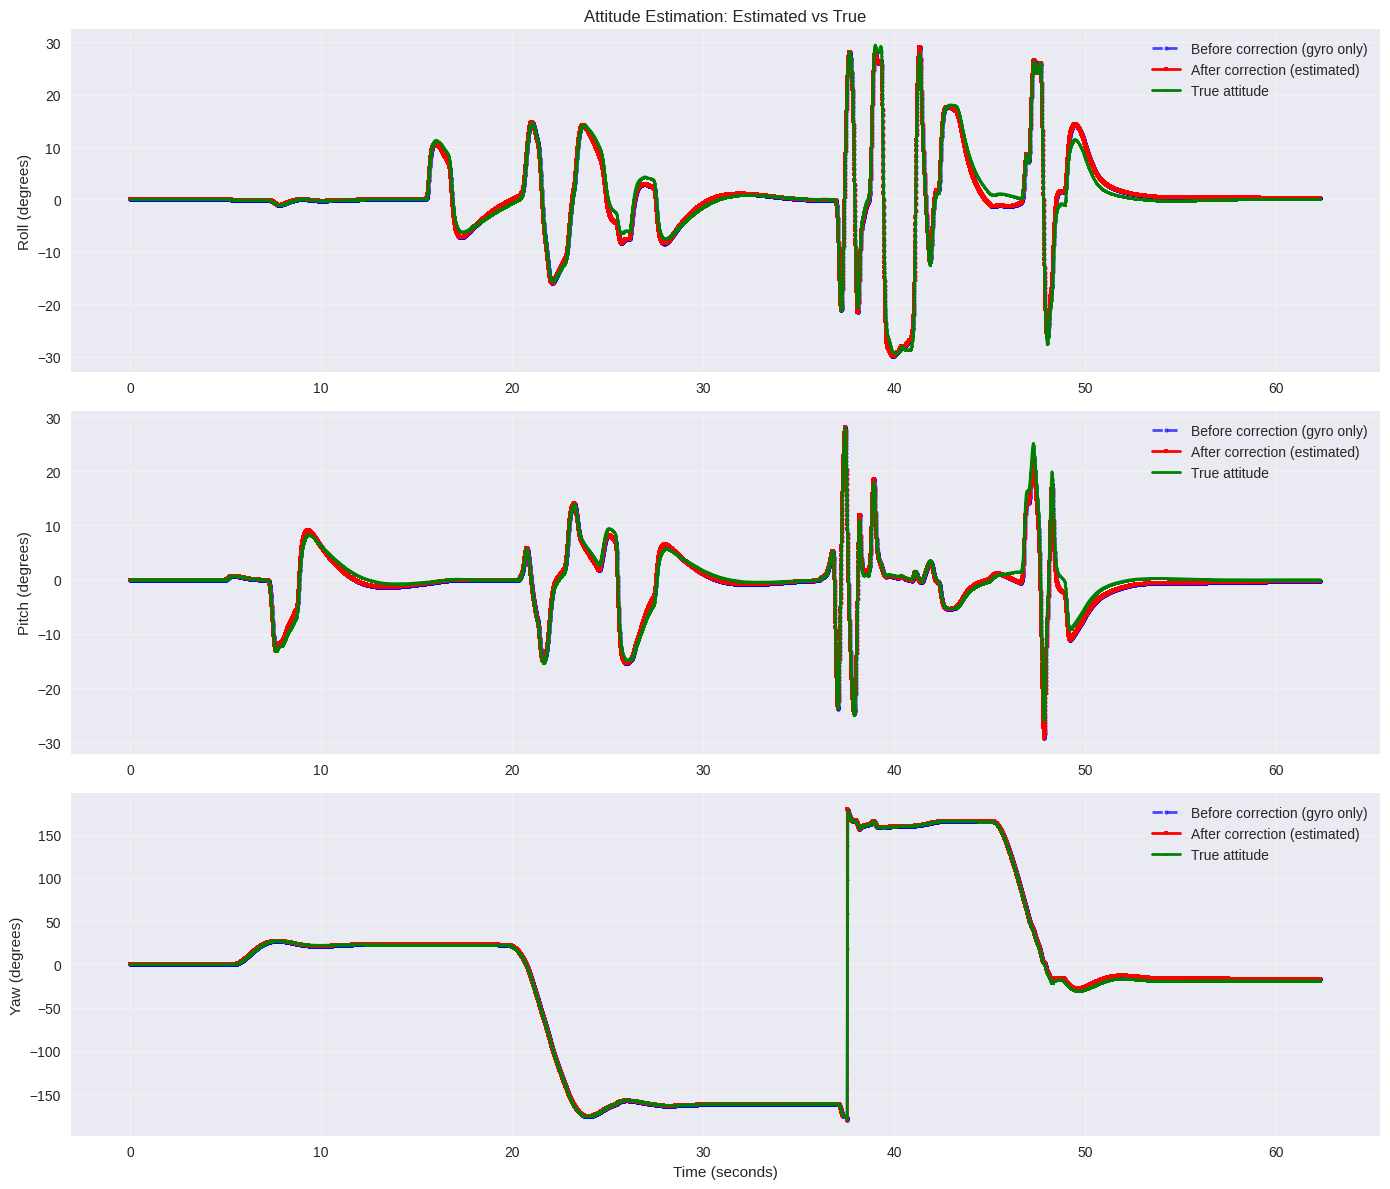

In [243]:
if 'time_array' in locals():
    # Plot attitude comparison
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Roll
    axes[0].plot(time_array, euler_before[:, 0], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[0].plot(time_array, euler_after[:, 0], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[0].plot(time_array, true_attitude_interp['roll'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[0].set_ylabel('Roll (degrees)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('Attitude Estimation: Estimated vs True')
    
    # Pitch
    axes[1].plot(time_array, euler_before[:, 1], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[1].plot(time_array, euler_after[:, 1], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[1].plot(time_array, true_attitude_interp['pitch'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[1].set_ylabel('Pitch (degrees)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Yaw
    axes[2].plot(time_array, euler_before[:, 2], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[2].plot(time_array, euler_after[:, 2], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[2].plot(time_array, true_attitude_interp['yaw'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[2].set_ylabel('Yaw (degrees)')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot!")


In [244]:
## Error Analysis: Estimated vs True Attitude


Removed 14 problematic points, keeping 15568 clean points
=== ATTITUDE ESTIMATION ERROR STATISTICS ===
\nAfter Correction (Clean Data):
  Roll : Mean =   0.01°, Std =   0.98°, RMS =   0.98°
  Pitch: Mean =  -0.34°, Std =   0.74°, RMS =   0.82°
  Yaw  : Mean =   0.71°, Std =   1.31°, RMS =   1.49°


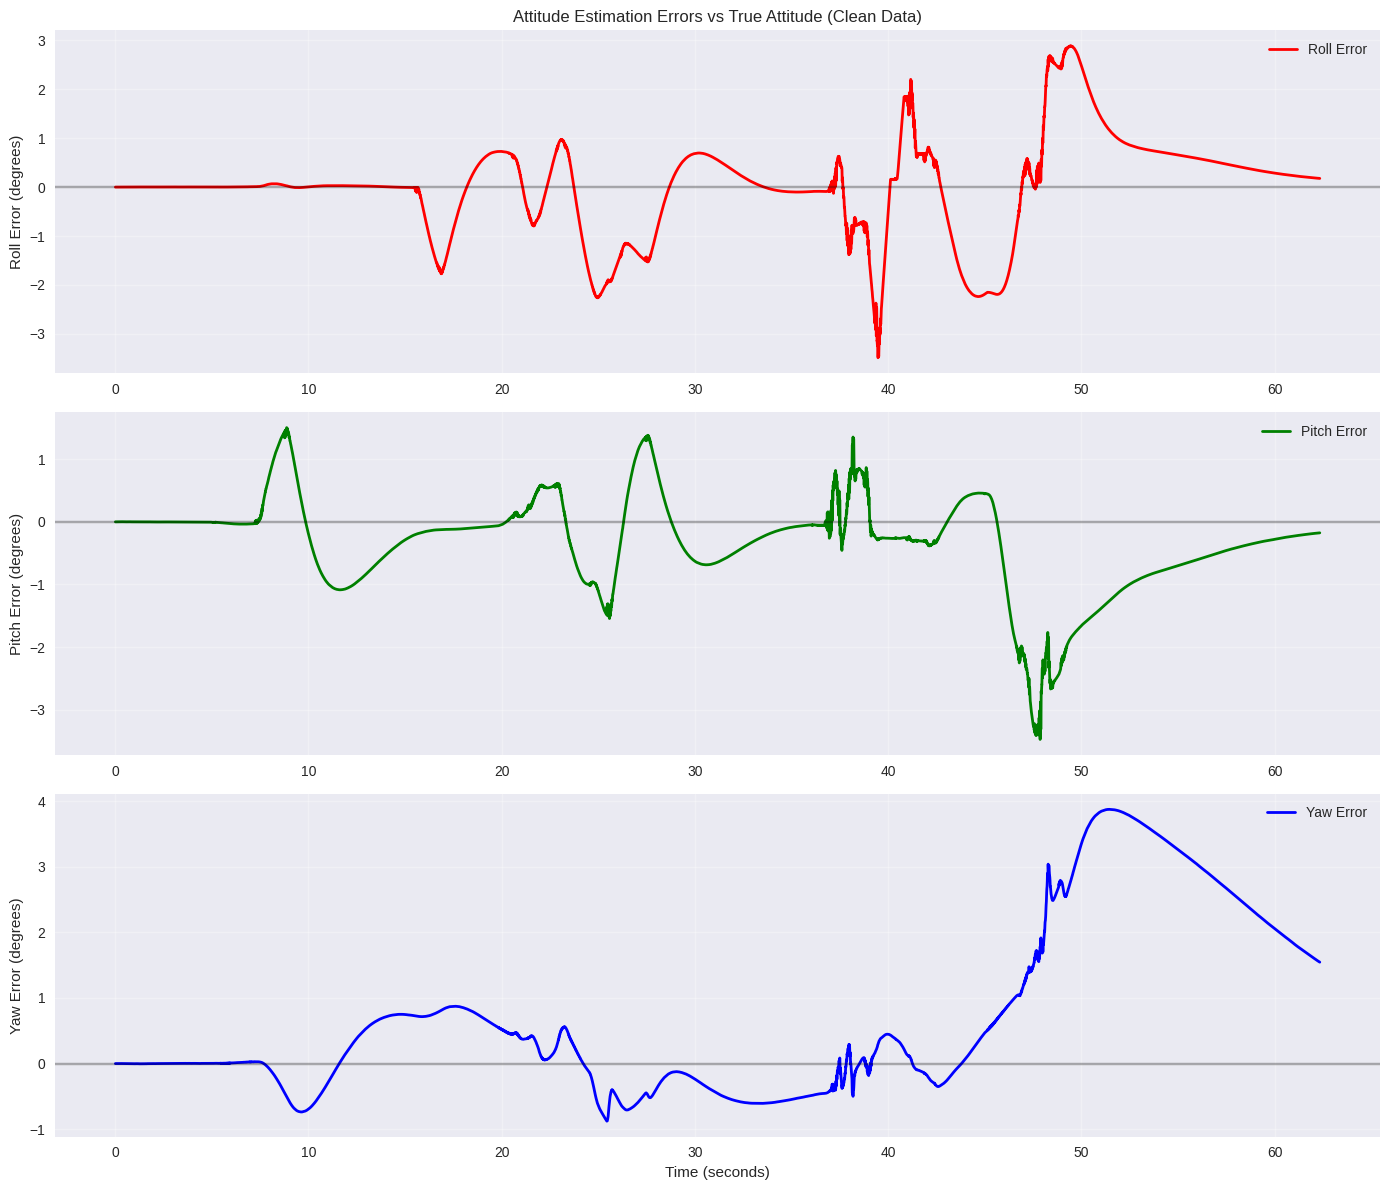

In [245]:
if 'time_array' in locals():
    # Calculate errors between estimated and true attitudes
    true_euler = np.array([
        true_attitude_interp['roll'].iloc[:len(time_array)].values,
        true_attitude_interp['pitch'].iloc[:len(time_array)].values, 
        true_attitude_interp['yaw'].iloc[:len(time_array)].values
    ]).T
    
    # Calculate errors (estimated - true)
    error_after = euler_after - true_euler
    
    # Handle angle wrapping for yaw errors (wrap to [-180, 180])
    def wrap_angle_degrees(angles):
        """Wrap angles to [-180, 180] degrees"""
        return np.mod(angles + 180, 360) - 180
    
    def detect_yaw_discontinuities(yaw_errors, threshold=150):
        """Detect points where yaw error jumps > threshold degrees between consecutive samples"""
        if len(yaw_errors) < 2:
            return np.ones(len(yaw_errors), dtype=bool)
        
        yaw_diff = np.abs(np.diff(yaw_errors))
        large_jumps = yaw_diff > threshold
        
        valid_mask = np.ones(len(yaw_errors), dtype=bool)
        jump_indices = np.where(large_jumps)[0]
        
        for idx in jump_indices:
            # Mark points around the jump as invalid
            start_idx = max(0, idx - 1)
            end_idx = min(len(valid_mask), idx + 3)
            valid_mask[start_idx:end_idx] = False
        
        return valid_mask
    
    def detect_unwrapping_issues(estimated_yaw, true_yaw, threshold=150):
        """Detect unwrapping issues by looking for sudden jumps in either signal"""
        est_jumps = np.abs(np.diff(estimated_yaw)) > threshold
        true_jumps = np.abs(np.diff(true_yaw)) > threshold
        
        valid_mask = np.ones(len(estimated_yaw), dtype=bool)
        all_jumps = np.where(np.logical_or(est_jumps, true_jumps))[0]
        
        for idx in all_jumps:
            start_idx = max(0, idx - 2)
            end_idx = min(len(valid_mask), idx + 4)
            valid_mask[start_idx:end_idx] = False
        
        return valid_mask
    
    # Wrap yaw errors
    error_after[:, 2] = wrap_angle_degrees(error_after[:, 2])
    
    # Create combined mask for all problematic points
    yaw_discontinuity_mask = detect_yaw_discontinuities(error_after[:, 2], threshold=150)
    yaw_unwrapping_mask = detect_unwrapping_issues(euler_after[:, 2], true_euler[:, 2], threshold=30)
    yaw_magnitude_mask = np.abs(error_after[:, 2]) < 170
    
    # Combined mask - keep only clean points
    valid_mask = np.logical_and.reduce([
        yaw_discontinuity_mask, 
        yaw_unwrapping_mask, 
        yaw_magnitude_mask,
    ])
    
    # Filter all data arrays to keep only valid points
    time_array = time_array[valid_mask]
    error_after = error_after[valid_mask]
    euler_after = euler_after[valid_mask]
    true_euler = true_euler[valid_mask]
    
    print(f"Removed {np.sum(~valid_mask)} problematic points, keeping {len(time_array)} clean points")
    
    # Calculate clean statistics
    labels = ['Roll', 'Pitch', 'Yaw']
    
    print("=== ATTITUDE ESTIMATION ERROR STATISTICS ===")
    print("\\nAfter Correction (Clean Data):")
    for i, label in enumerate(labels):
        mean_error = np.mean(error_after[:, i])
        std_error = np.std(error_after[:, i])
        rms_error = np.sqrt(np.mean(error_after[:, i]**2))
        print(f"  {label:5}: Mean = {mean_error:6.2f}°, Std = {std_error:6.2f}°, RMS = {rms_error:6.2f}°")

    # Plot clean results
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Roll error
    axes[0].plot(time_array, error_after[:, 0], 'r-', label='Roll Error', linewidth=2)
    axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[0].set_ylabel('Roll Error (degrees)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('Attitude Estimation Errors vs True Attitude (Clean Data)')
    
    # Pitch error
    axes[1].plot(time_array, error_after[:, 1], 'g-', label='Pitch Error', linewidth=2)
    axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[1].set_ylabel('Pitch Error (degrees)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Yaw error
    axes[2].plot(time_array, error_after[:, 2], 'b-', label='Yaw Error', linewidth=2)
    axes[2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[2].set_ylabel('Yaw Error (degrees)')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    #axes[2].set_ylim(-10, 10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No results to analyze!")

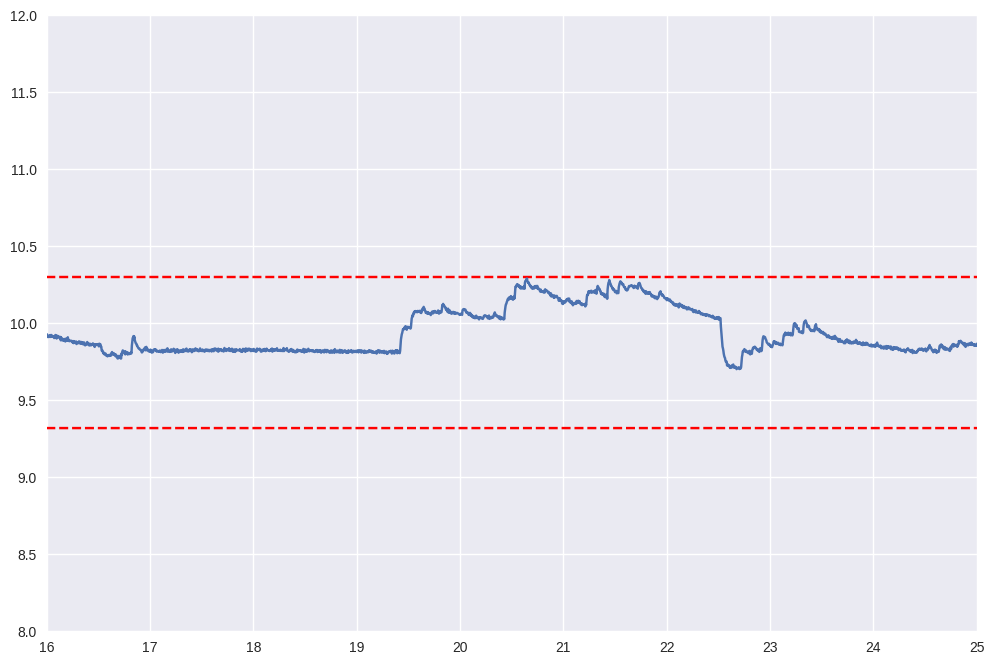

In [246]:
threshold = 0.05
accel_norm = np.sqrt(imu_data['accel_x']**2 + imu_data['accel_y']**2 + imu_data['accel_z']**2)
g_high = 9.81 * (1.0 + threshold)
g_low = 9.81 * (1.0 - threshold)
plt.plot(imu_data['timestamp'], g_high * np.ones(len(imu_data['timestamp'])), 'r--')
plt.plot(imu_data['timestamp'], g_low * np.ones(len(imu_data['timestamp'])), 'r--')
plt.plot(imu_data['timestamp'], accel_norm)
plt.xlim(16, 25)
plt.ylim(8, 12)
plt.show()
